## Принятие решений в бизнесе
Данный проект будет разбит на две части:

Часть 1. Приоритизация гипотез.

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

-Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

-Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

-Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

Часть 2. Анализ A/B-теста

Проанализируйте A/B-тест:

Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.

Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.
Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

Сделайте выводы и предположения.

Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.

Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

Примите решение по результатам теста и объясните его. Варианты решений:

1. Остановить тест, зафиксировать победу одной из групп.

2. Остановить тест, зафиксировать отсутствие различий между группами.

3. Продолжить тест.

Перед первой часть выполним первичный обзор данных, предобработку и посмотрим на данные в различных срезах

## Описание данных

Файл /datasets/hypothesis.csv

Hypothesis — краткое описание гипотезы;

Reach — охват пользователей по 10-балльной шкале;

Impact — влияние на пользователей по 10-балльной шкале;

Confidence — уверенность в гипотезе по 10-балльной шкале;

Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv.

transactionId — идентификатор заказа;

visitorId — идентификатор пользователя, совершившего заказ;

date — дата, когда был совершён заказ;

revenue — выручка заказа;

group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv.

date — дата;

group — группа A/B-теста;

visitors — количество пользователей в указанную дату в указанной группе A/B-теста

# Загрузка данных и предобработка

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import pandas as pd
import numpy as np
import re

In [3]:
visitors = pd.read_csv('/datasets/visitors.csv')
orders = pd.read_csv('/datasets/orders.csv')
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 200)

## Посмотрим на данные, а точнее на их типы

In [4]:
print(visitors.info())
print(orders.info())
print(hypothesis.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypot

Изменим тип данных для дат

In [5]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Смотреть на неявные дубликаты на мой взгляд нет смысла ведь таблица visitors содержит агрегированные данные и что-то с ними делать не целесообразно

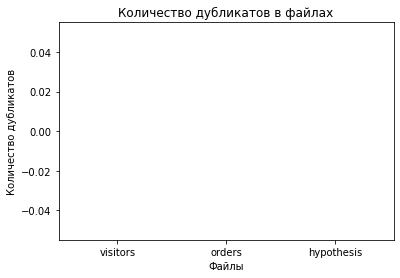

In [6]:
duplicates_visitors = visitors.duplicated().sum()
duplicates_orders = orders.duplicated().sum()
duplicates_hypothesis = hypothesis.duplicated().sum()

# Создание словаря для удобства отображения на графике
duplicates_dict = {
    'visitors': duplicates_visitors,
    'orders': duplicates_orders,
    'hypothesis': duplicates_hypothesis
}

# Построение столбчатого графика
plt.bar(duplicates_dict.keys(), duplicates_dict.values())
plt.title('Количество дубликатов в файлах')
plt.xlabel('Файлы')
plt.ylabel('Количество дубликатов')
plt.show()

Явных дубликатов нет

## Часть 1. Приоритизация гипотез.

## Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [7]:
hypothesis['ICE'] = round(hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'],2)

In [8]:
hypothesis.sort_values('ICE', ascending=False).head()

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00


### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [9]:
hypothesis['RICE'] = round(hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'],2)

In [9]:
hypothesis.sort_values('RICE', ascending=False).head()

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2


Стоит обратить внимание, что RICE учитывает охват, что в моем понимании позволит дать более точную оценку. Из-за него скорее всего и приоритезация гипотез меняется. Нужно отдать приоритет гипотезе №7 из-за охвата нежели гипотезу №8 оценкой фреймворком ICE

<div class="alert alert-info"> <b>Стоит обратить внимание, что RICE учитывает охват, что в моем понимании позволит дать более точную оценку. Из-за него скорее всего и приоритезация гипотез меняется. Нужно отдать приоритет гипотезе "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	" из-за охвата нежели гипотезу "Запустить акцию, дающую скидку на товар в день рождения" оценкой фреймворком ICE: </b> </div>

# Часть 2. Анализ A/B-теста

## Проанализируйте A/B-тест:

### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

Чтобы построить графики, прежде всего нужно собрать кумулятивные данные в таблицу:

создать базу уникальных пар значений дат и групп теста

получить агрегированные кумулятивные по дням данные о заказах

получить агрегированные кумулятивные по дням данные о посетителях интернет-магазина

объединить кумулятивные данные в одной таблице и присвоить её столбцам понятные названия

In [10]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [14]:
dates_grps = orders[['date','group']].drop_duplicates()

orders_agg = dates_grps.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date':'max', 'group':'max', 'transactionId':'nunique', 'visitorId':'nunique', 'revenue':'sum'}), axis=1
).sort_values(by=['date', 'group'])

visitors_agg = dates_grps.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis=1
).sort_values(by=['date','group'])

cumulative_data = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
print(cumulative_data.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


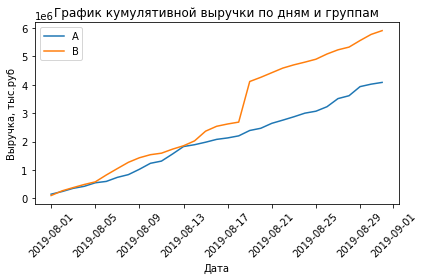

In [16]:
def plot_cumulative_revenue(cumulative_data, group_label):
    data = cumulative_data[cumulative_data['group'] == group_label][['date', 'revenue', 'orders']]
    plt.plot(data['date'], data['revenue'], label=group_label)

# Построение графика для каждой группы
plot_cumulative_revenue(cumulative_data, 'A')
plot_cumulative_revenue(cumulative_data, 'B')

# Настройка параметров графика
plt.title('График кумулятивной выручки по дням и группам')
plt.xlabel('Дата')
plt.ylabel('Выручка, тыс.руб')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


В первой половине выручка группы B немного больше, но второй половине видим скачок 17 числа. Из предположений это анамалии, либо прирост конверсии. Выручка группы А сохраняет плавный(ровномерный) рост

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

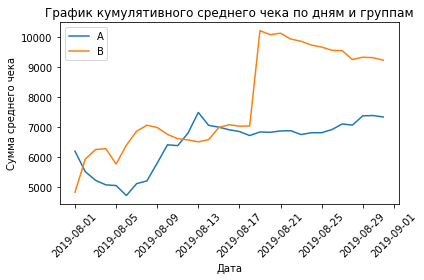

In [22]:
def plot_average_check(cumulative_data, group_label):
    group_data = cumulative_data[cumulative_data['group'] == group_label]
    average_check = group_data['revenue'] / group_data['orders']
    plt.plot(group_data['date'], average_check, label=group_label)

plot_average_check(cumulative_data, 'A')
plot_average_check(cumulative_data, 'B')


plt.title('График кумулятивного среднего чека по дням и группам')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Для лучшего отображения при малом пространстве
plt.show()

Перепады группы А выглядят естесствено, нежели еще более резкий скачок группы B

### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

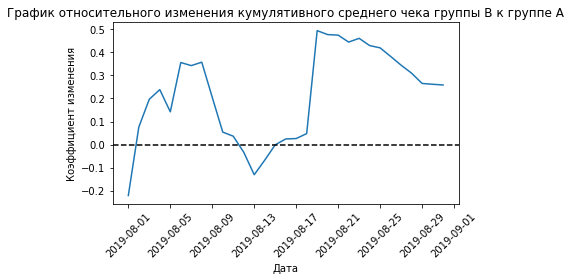

In [24]:
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]
def plot_relative_change(cumulative_revenue_a, cumulative_revenue_b):
    merged_data = cumulative_revenue_a.merge(
        cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])
    
   
    relative_change = (merged_data['revenue_b'] / merged_data['orders_b']) / \
                      (merged_data['revenue_a'] / merged_data['orders_a']) - 1
    
    
    plt.plot(merged_data['date'], relative_change)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
    plt.xlabel('Дата')
    plt.ylabel('Коэффициент изменения')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_relative_change(cumulative_revenue_a, cumulative_revenue_b)

Изменение нестабильно и очень резкие перепады

### Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.

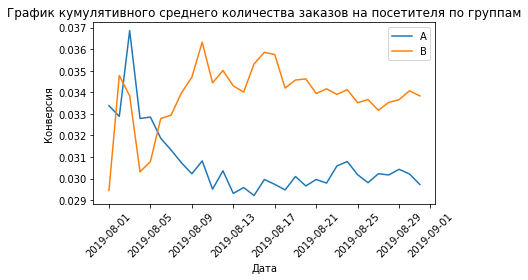

In [27]:
def plot_conversion_by_group(cumulative_data, group_label):
    group_data = cumulative_data[cumulative_data['group'] == group_label].copy()
    group_data.loc[:, 'conversion'] = group_data['orders'] / group_data['visitors']
    plt.plot(group_data['date'], group_data['conversion'], label=group_label)

plot_conversion_by_group(cumulative_data, 'A')
plot_conversion_by_group(cumulative_data, 'B')

plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

В начале исследования группа A демонстрирует более высокие значения. В начальный период наблюдается волатильность в обеих группах, когда показатели колеблются вверх и вниз. После этого периода, показатели группы A идут на спад, в то время как группа B показывает тенденцию к увеличению количества заказов.

### Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

In [35]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

In [40]:
cumulative_data_a['conversion'] = cumulative_data_a['orders'] / cumulative_data_a['visitors']
cumulative_data_b['conversion'] = cumulative_data_b['orders'] / cumulative_data_b['visitors']

/tmp/ipykernel_94/1740782206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulative_data_a['conversion'] = cumulative_data_a['orders'] / cumulative_data_a['visitors']
/tmp/ipykernel_94/1740782206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumulative_data_b['conversion'] = cumulative_data_b['orders'] / cumulative_data_b['visitors']


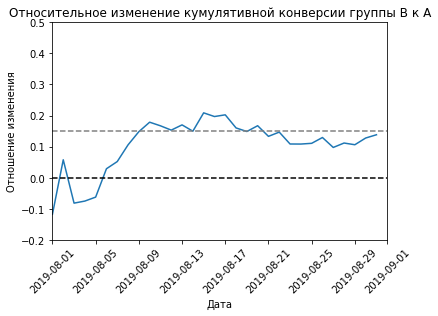

In [41]:
merged_cumulative_conversions = cumulative_data_a[['date', 'conversion']].merge(
    cumulative_data_b[['date', 'conversion']],
    on='date',
    how='left',
    suffixes=['_a', '_b']
)

# Построение графика относительного изменения кумулятивной конверсии
plt.plot(
    merged_cumulative_conversions['date'],
    merged_cumulative_conversions['conversion_b'] /
    merged_cumulative_conversions['conversion_a'] - 1
)

# Горизонтальные линии для визуальной ориентации
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')

# Настройка заголовка и осей графика
plt.title('Относительное изменение кумулятивной конверсии группы B к A')
plt.xlabel('Дата')
plt.ylabel('Отношение изменения')

# Установка пределов для осей
plt.axis([
    pd.to_datetime('2019-08-01'),
    pd.to_datetime('2019-09-01'),
    -0.2, 0.5
])

# Поворот меток на оси X для лучшей читаемости
plt.xticks(rotation=45)

# Отображение графика
plt.show()

Относительный показатель изменения среднего числа заказов достигает устойчивости во второй части испытания, демонстрируя результаты, превосходящие показатели группы А.

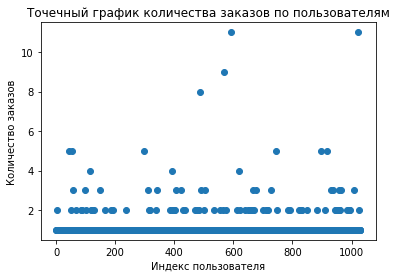

In [43]:
orders_by_users = orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
orders_by_users.columns = ['user_id', 'orders']
x_values_orders = pd.Series(range(0,len(orders_by_users)))
plt.scatter(x_values_orders, orders_by_users['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Индекс пользователя')
plt.ylabel('Количество заказов');

На одного пользователя приходится более двух заказов, что является нечастым явлением.

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [44]:
print(np.percentile(orders_by_users['orders'], [95, 99])) 

[2. 4.]


Данные, соответствующие 95-му перцентилю, подтверждают гипотезу: всего 5% пользователей сделали более двух заказов.

### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

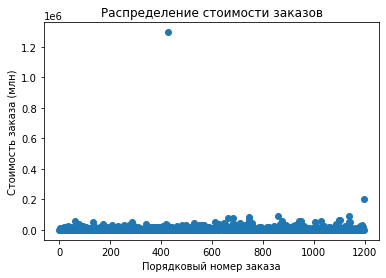

In [45]:
x_values_revenue = pd.Series(range(len(orders['revenue'])))

# Строим точечный график, где каждая точка представляет стоимость заказа
plt.scatter(x_values_revenue, orders['revenue'])

# Задаем название графика и подписи осей
plt.title('Распределение стоимости заказов')
plt.xlabel('Порядковый номер заказа')
plt.ylabel('Стоимость заказа (млн)')
plt.show()

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [47]:
revenue_stats = orders['revenue'].describe().astype(str)
print(revenue_stats)

count               1197.0
mean     8348.005847953216
std      39191.13177395123
min                   50.0
25%                 1220.0
50%                 2978.0
75%                 8290.0
max              1294500.0
Name: revenue, dtype: object


Анализ данных выявляет аномально высокую стоимость одного из заказов, почти в 1.3 миллиона, что резко контрастирует с медианным значением заказа в 3 тысячи. Это указывает на возможное наличие выбросов в данных.

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [48]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Менее пяти процентов заказов имеют стоимость свыше 28 тысяч, а менее одного процента заказов стоят более 58.2 тысяч.

###  Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Нулевая гипотеза (Н0): Среднее количество заказов одинаково для всех групп.

Альтернативная гипотеза (Н1): Существуют отличия в среднем количестве заказов между группами.

Уровень значимости: α=0.05

In [51]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']]
    .agg({'date': 'max', 'visitors_per_date_a':'sum'}), axis=1)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']]
    .agg({'date':'max', 'visitors_per_date_b':'sum'}), axis=1)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

orders_a_daily = (orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue':'sum'}))
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']]
    .agg({'date':'max', 'orders_per_date_a':'sum', 'revenue_per_date_a':'sum'}), axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = ['date', 'orders_cummulative_a', 'revenue_cummulative_a']

orders_b_daily = (orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue':'sum'}))
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']]
    .agg({'date':'max', 'orders_per_date_b':'sum', 'revenue_per_date_b':'sum'}), axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = ['date', 'orders_cummulative_b', 'revenue_cummulative_b',]

data = (orders_a_daily
    .merge(orders_b_daily, left_on='date', right_on='date', how='left')
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left'))

print(data.head(5))

        date  orders_per_date_a  revenue_per_date_a  orders_per_date_b  \
0 2019-08-01                 24              148579                 21   
1 2019-08-02                 20               93822                 24   
2 2019-08-03                 24              112473                 16   
3 2019-08-04                 16               70825                 17   
4 2019-08-05                 25              124218                 23   

   revenue_per_date_b  orders_cummulative_a_x  revenue_cummulative_a_x  \
0              101217                      24                   148579   
1              165531                      44                   242401   
2              114248                      68                   354874   
3              108571                      84                   425699   
4               92428                     109                   549917   

   orders_cummulative_b_x  revenue_cummulative_b_x  visitors_per_date_a  \
0                      21          

In [52]:
orders_by_users_a = (orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))
orders_by_users_b.columns = ['visitor_id', 'orders']

sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(0, index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')], axis=0)

sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(0, index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')], axis=0)

In [53]:
p_value = stats.mannwhitneyu(sample_a, sample_b).pvalue
print(f"p-value: {p_value:.3f}")

# Рассчитываем процентное изменение среднего значения группы B по сравнению с группой A
percentage_change = ((sample_b.mean() / sample_a.mean()) - 1) * 100
print(f"Изменение группы B к А: {percentage_change:.1f}%")

p-value: 0.017
Изменение группы B к А: 13.8%


P-значение меньше заданного уровня значимости, что приводит к отклонению нулевой гипотезы об идентичности среднего количества заказов в обеих группах. В то же время, объем заказов в группе B на 13,8% выше, чем в группе A.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения

Н0: Средний чек по заказам в обеих группах одинаков.

Н1: Существует разница в среднем чеке между группами.

Установленный уровень значимости: α=0.05

In [54]:
orders_a = orders[orders['group'] == 'A']['revenue']
orders_b = orders[orders['group'] == 'B']['revenue']

# Вычисляем p-value для теста Манна-Уитни между двумя группами
p_value = stats.mannwhitneyu(orders_a, orders_b).pvalue
print(f"p-value: {p_value:.3f}")

# Рассчитываем процентное изменение среднего дохода группы B по сравнению с группой A
percentage_change = (orders_b.mean() / orders_a.mean() - 1) * 100
print(f"Изменение группы B к А: {percentage_change:.1f}%")

p-value: 0.729
Изменение группы B к А: 25.9%


Значение P-value значительно превышает установленный порог статистической значимости, что позволяет нам принять нулевую гипотезу о том, что различий в среднем чеке между группами нет. Тем не менее, анализ необработанных данных указывает на то, что средний чек группы B выше на 25,9% по сравнению с группой A.

### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.

Н0: Нет статистически значимого различия в среднем количестве заказов между группами.

Н1: Имеется статистически значимое различие в среднем количестве заказов между группами.

Уровень значимости установлен на отметке: α=0.05

Для очистки данных необходимо исключить выбросы, опираясь на ранее определённые 95-й и 99-й перцентили. В этом контексте следует отфильтровать пользователей с аномально высокими показателями: тех, кто входит в 5% с наибольшим количеством заказов, и тех, чьи заказы превышают 35 тысяч — от 1% до 5% таких пользователей.

In [57]:
users_with_many_orders = pd.concat([
    orders_by_users_a[orders_by_users_a['orders'] > 2]['visitor_id'],
    orders_by_users_b[orders_by_users_b['orders'] > 2]['visitor_id']
], axis=0)

# Выбираем пользователей с заказами дороже 35000
users_with_expensive_orders = orders[orders['revenue'] > 35000]['visitorId']

# Объединяем списки аномальных пользователей и удаляем дубликаты
abnormal_users = pd.concat([
    users_with_many_orders, 
    users_with_expensive_orders
], axis=0).drop_duplicates().sort_values()

# Выводим список аномальных пользователей
print('Список аномальных пользователей:')
print(abnormal_users.head(5))
print()

# Выводим количество аномальных пользователей
print('Количество аномальных пользователей:', abnormal_users.shape[0])

Список аномальных пользователей:
1099    148427295
18      199603092
23      237748145
37      249864742
684     358944393
dtype: int64

Количество аномальных пользователей: 53


In [62]:
filtered_sample_a = pd.concat([
    orders_by_users_a[~orders_by_users_a['visitor_id'].isin(abnormal_users)]['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - orders_by_users_a['orders'].shape[0]), name='orders')
], axis=0)

# Создаем фильтрованную выборку для группы B
filtered_sample_b = pd.concat([
    orders_by_users_b[~orders_by_users_b['visitor_id'].isin(abnormal_users)]['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - orders_by_users_b['orders'].shape[0]), name='orders')
], axis=0)

# Вычисляем p-value теста Манна-Уитни
mannwhitney_p_value = stats.mannwhitneyu(filtered_sample_a, filtered_sample_b)[1]
print(f"p-value: {mannwhitney_p_value:.3f}")

# Вычисляем относительное изменение среднего количества заказов между группами
relative_difference = (filtered_sample_b.mean() / filtered_sample_a.mean() - 1) * 100
print(f"Изменение группы B к А: {relative_difference:.1f}%")

p-value: 0.010
Изменение группы B к А: 17.9%


Так же, как и при анализе необработанных данных, нулевая гипотеза была отклонена. Показатель изменения среднего числа заказов в фильтрованных данных немного больше и достигает 17,9%.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

Н0: Средний чек заказа одинаков для обеих групп.

Н1: Существует разница в среднем чеке заказа между группами.

Уровень значимости установлен на α = 0.05.

In [63]:
p_value = stats.mannwhitneyu(
    orders[(orders['group'] == 'A') & (~orders['visitorId'].isin(abnormal_users))]['revenue'],
    orders[(orders['group'] == 'B') & (~orders['visitorId'].isin(abnormal_users))]['revenue']
)[1]
print(f"p-value: {p_value:.3f}")

# Вычисляем изменение дохода группы B по сравнению с группой A
revenue_increase = (
    orders[(orders['group'] == 'B') & (~orders['visitorId'].isin(abnormal_users))]['revenue'].mean() /
    orders[(orders['group'] == 'A') & (~orders['visitorId'].isin(abnormal_users))]['revenue'].mean() - 1
) * 100
print(f"Изменение группы B к А: {revenue_increase:.1f}%")

p-value: 0.885
Изменение группы B к А: 2.2%


Исходя из значения p-value, можно сделать вывод, что нет оснований отвергать нулевую гипотезу о том, что средние чеки групп не различаются. Однако после исключения аномалий данные указывают на то, что разница в средних чеках между группами невелика и составляет 2,2%, в то время как анализ неочищенных данных показывал разницу в 25,9%.

## Примите решение по результатам теста и объясните его.

Результаты анализа демонстрируют увеличение конверсии в группе B, а также рост числа заказов при сохранении одинаковой суммы средних чеков. В свете этих данных было принято решение завершить тестирование и объявить группу B победителем.

## Вывод.

В ходе A/B тестирования было обнаружено, что 58 участников ошибочно вошли в обе тестируемые группы, и коррекция этой ошибки в собранных данных невозможна. Используя фреймворки ICE и RICE, был выполнен процесс приоритизации идей, что позволило подготовить и проверить гипотезы. Анализ кумулятивных метрик через визуализацию дал возможность наблюдать за динамикой изменений во время теста и сформировать целостное восприятие его прогресса. После выявления аномалий, которые могли повлиять на статистическую значимость, данные были очищены, что позволило сделать обоснованное решение о завершении или продолжении теста. Наблюдаемое увеличение кумулятивной выручки и числа заказов в группе B, при этом средний чек остался без изменений, указывает на успешность группы B.

Несмотря на проблемы с формированием групп, результаты теста подтверждают эффективность внедряемых изменений в группе B, что может быть рассмотрено как основание для масштабирования данных изменений на более широкую аудиторию.